In [1]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from transformers import get_cosine_schedule_with_warmup
import numpy as np
from datasets import Dataset as HFDataset
from pathlib import Path


from src.dataset import HistologicalImageDataset
from src.trainer import ModelTrainer, TrainingArguments
from src.modelling import ViT_UCB_Pruning 

print(f"PyTorch: {torch.__version__}")
print(f"Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")

/data2/home/vcivale/UNI_UCB2/refactored_repo/.venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch: 2.8.0+cu128
Device: cuda


In [2]:
DATA_DIR = "/data2/home/vcivale/UNI_UCB2/refactored_repo/CRC-VAL-HE-7K"
OUTPUT_DIR = "./results_test"

# Hyperparameters
IMG_SIZE = 224
BATCH_SIZE = 16
LEARNING_RATE = 1e-3
NUM_EPOCHS = 2  # Small for testing
WARMUP_STEPS = 100

# Model
KEEP_RATIO = 1.0  # Stage 1: no pruning
BETA = 1.0
INPUT_AWARE_WEIGHT = 0.7

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

In [4]:
# STEP 2: Create datasets (fast - reuses hf_dataset)
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225)
    ),
])

train_dataset = HistologicalImageDataset(
    data_dir=DATA_DIR,
    transform=transform,
    split='train',
    test_size=0.2,
    seed=SEED
)

val_dataset = HistologicalImageDataset(
    data_dir=DATA_DIR,
    transform=transform,
    split='val',
    test_size=0.2,
    seed=SEED
)

print(f"\nClasses: {train_dataset.class_names}")
print(f"Num classes: {len(train_dataset.class_names)}")

TRAIN: 5744 samples, 9 classes


Pre-loading images: 100%|██████████| 5744/5744 [00:04<00:00, 1200.65it/s]


VAL: 1436 samples, 9 classes


Pre-loading images: 100%|██████████| 1436/1436 [00:01<00:00, 1154.65it/s]


Classes: [0, 1, 2, 3, 4, 5, 6, 7, 8]
Num classes: 9


In [5]:
# Balance classes
from torch.utils.data import WeightedRandomSampler

class_counts = np.bincount(train_dataset.labels)
class_weights = 1.0 / class_counts
sample_weights = torch.from_numpy(class_weights[train_dataset.labels]).double()

train_sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

print("Class weights:")
for i, (name, weight) in enumerate(zip(train_dataset.class_names, class_weights)):
    print(f"  {name}: {weight:.4f} (count: {class_counts[i]})")



Class weights:
  0: 0.0009 (count: 1070)
  1: 0.0015 (count: 678)
  2: 0.0037 (count: 271)
  3: 0.0020 (count: 507)
  4: 0.0012 (count: 828)
  5: 0.0021 (count: 474)
  6: 0.0017 (count: 593)
  7: 0.0030 (count: 337)
  8: 0.0010 (count: 986)


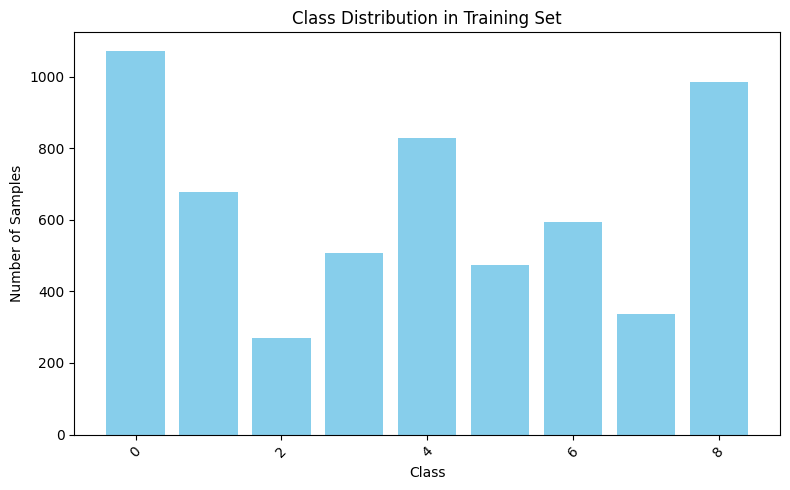

In [6]:
#plot label distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.bar(train_dataset.class_names, class_counts, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Training Set')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [7]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=train_sampler,
    num_workers=8,  # Increase for faster loading
    pin_memory=True,
    persistent_workers=True,
    drop_last=True,
    prefetch_factor=4  # Pre-load 4 batches per worker
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=8,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=4
)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

Train batches: 359
Val batches: 90


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ViT_UCB_Pruning(
    model_name="hf-hub:MahmoodLab/uni",
    pretrained=True,
    n_classes=len(train_dataset.class_names),
    keep_ratio=KEEP_RATIO,
    beta=BETA,
    input_aware_weight=INPUT_AWARE_WEIGHT,
    exclude_cls=True
)

model.gradient_checkpointing_enable()

print(f"Model: {type(model).__name__}")
print(f"Device: {device}")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total params: {total_params:,}")
print(f"Trainable params: {trainable_params:,}")

2026-01-10 17:30:35 - INFO - Loading pretrained weights from Hugging Face hub (MahmoodLab/uni)


Model: ViT_UCB_Pruning
Device: cuda
Total params: 303,360,009
Trainable params: 303,360,009


In [9]:
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=0.01
)

num_training_steps = NUM_EPOCHS * len(train_loader)
scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=WARMUP_STEPS,
    num_training_steps=num_training_steps
)

print(f"Total training steps: {num_training_steps}")
print(f"Warmup steps: {WARMUP_STEPS}")

Total training steps: 718
Warmup steps: 100


In [10]:
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    run_name="nct-crc-test",
    num_train_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    train_batch_size=BATCH_SIZE,
    eval_batch_size=BATCH_SIZE,
    warmup_steps=WARMUP_STEPS,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_steps=50,
    fp16=False,
    save_best_model=True,
    save_total_limit=1,
    early_stopping_patience=0,
    report_to="wandb",  # Change to "wandb" if you want tracking
    model_type="ucb",
    input_aware_weight=INPUT_AWARE_WEIGHT
)

In [11]:
trainer = ModelTrainer(
    model=model,
    args=training_args,
    train_dataloader=train_loader,
    eval_dataloader=val_loader,
    class_names=train_dataset.class_names,
    optimizers=(optimizer, scheduler),
    device=device
)

print("Trainer initialized successfully!")

2026-01-10 17:30:39 - INFO - Model type: ucb
2026-01-10 17:30:39 - INFO - Total training steps: 718
/data2/home/vcivale/UNI_UCB2/refactored_repo/src/trainer.py:123: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = GradScaler(enabled=self.args.fp16)
wandb: Currently logged in as: vincenzo-civale (vincenzo-civale-universi-degli-studi-di-firenze) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Trainer initialized successfully!


In [12]:
trainer.train()

2026-01-10 17:30:42 - INFO - ============================================================
2026-01-10 17:30:42 - INFO - Starting Training
2026-01-10 17:30:42 - INFO -   Epochs: 2
2026-01-10 17:30:42 - INFO -   Steps: 718
2026-01-10 17:30:42 - INFO -   Model: ucb
2026-01-10 17:30:42 - INFO - ============================================================
Epoch 1:   0%|          | 0/359 [00:00<?, ?it/s]/data2/home/vcivale/UNI_UCB2/refactored_repo/src/trainer.py:272: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.args.fp16):
Epoch 1: 100%|██████████| 359/359 [06:45<00:00,  1.13s/it, loss=0.5674, lr=6.26e-04]
2026-01-10 17:37:27 - INFO - Epoch 1 completed
2026-01-10 17:37:27 - INFO - Running evaluation at step 359
Evaluating:   0%|          | 0/90 [00:00<?, ?it/s]/data2/home/vcivale/UNI_UCB2/refactored_repo/src/trainer.py:319: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated.

eval/accuracy,▁█
eval/f1,▁█
eval/loss,█▁
train/epoch,▁▁▁▁▁▁▁▁████████
train/learning_rate,▄███▇▆▆▅▄▃▂▂▁▁
train/loss,▆█▆▅▄▄▃▃▂▂▂▁▁▁
train/step,▁▂▂▃▃▄▄▅▅▆▆▇▇█
eval/accuracy,0.95891
eval/f1,0.95176
eval/loss,0.12346
train/epoch,2


2026-01-10 17:45:49 - INFO - Training completed!
